# Learning to regress polynomial time series with a CNN
#### This is a Python3 notebook

In [49]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow import keras
Sequential = keras.models.Sequential
Conv1D = keras.layers.Conv1D


In [50]:
def create_model(window_size, hidden_size, seq_length=None, display_summary=True):
    """
    seq_length=None: flexible sequence length. recommended for actual usage.
    seq_length=NUMBER: recommended for model summary.
    """
    model = Sequential()
    model.add(Conv1D(name='window_conv', filters=hidden_size, kernel_size=window_size,
                     input_shape=(seq_length, 1), padding='valid', activation='relu'))
    model.add(Conv1D(name='hidden1', filters=hidden_size, kernel_size=1,
                     input_shape=(seq_length, hidden_size), activation='relu'))
    model.add(Conv1D(name='hidden2', filters=hidden_size, kernel_size=1,
                     input_shape=(seq_length, hidden_size), activation='relu'))
    model.add(Conv1D(name='regressor', filters=1, kernel_size=1,
                     input_shape=(seq_length, hidden_size)))
    model.compile(loss='mean_squared_error', optimizer='adam')
    if display_summary:
        model.summary()
    return model


In [51]:
def generate_polynomial_sequences(seq_length, num_seqs, degree=3, span=2):
    seq = np.zeros((num_seqs, seq_length))
    x = np.linspace(-span, span, seq_length)
    monoms = x[:, np.newaxis] ** range(degree + 1)
    coeffs = np.random.randn(num_seqs, degree + 1)
    polynomes = np.matmul(coeffs, monoms.T)
    return polynomes


In [52]:
def plot_preds(real, predicted, num_plot=5, title=None):
    plt.figure()
    if title is not None:
        plt.title(title)
    for i_poly in np.random.randint(y_test.shape[0], size=num_plot):
        color = np.random.rand(3) * 0.75
        plt.plot(real[i_poly,:], color=color)
        plt.plot(predicted[i_poly,:], '--', color=color)
    plt.show()


In [53]:
window_size = 10
hidden_size = 20
seq_length = 100
n_train = 1000
n_test = 1000


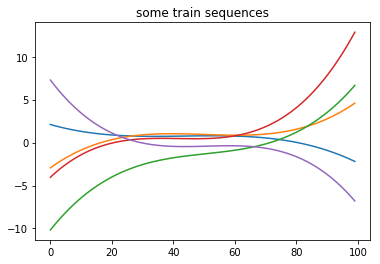

In [54]:
data_train = generate_polynomial_sequences(seq_length, n_train)
data_test = generate_polynomial_sequences(seq_length, n_test)

x_train = data_train[:, :-1, np.newaxis]
y_train = data_train[:, window_size:, np.newaxis]
x_test = data_test[:, :-1, np.newaxis]
y_test = data_test[:, window_size:, np.newaxis]

num_plot = 5
plot_inds = np.random.randint(data_train.shape[0], size=num_plot)
plt.figure()
plt.title('some train sequences')
plt.plot(data_train[plot_inds,:].T)
plt.show()


In [55]:
create_model(window_size, hidden_size, seq_length=seq_length)
model = create_model(window_size, hidden_size, display_summary=False)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
window_conv (Conv1D)         (None, 91, 20)            220       
_________________________________________________________________
hidden1 (Conv1D)             (None, 91, 20)            420       
_________________________________________________________________
hidden2 (Conv1D)             (None, 91, 20)            420       
_________________________________________________________________
regressor (Conv1D)           (None, 91, 1)             21        
Total params: 1,081
Trainable params: 1,081
Non-trainable params: 0
_________________________________________________________________


Epoch 1/1
1000/1000 [==============================] - 1s 1ms/step - loss: 5.9570


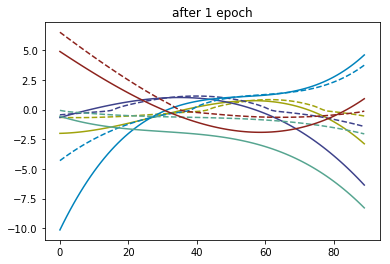

Epoch 1/2
1000/1000 [==============================] - 0s 288us/step - loss: 1.9919
Epoch 2/2
1000/1000 [==============================] - 0s 277us/step - loss: 0.7614


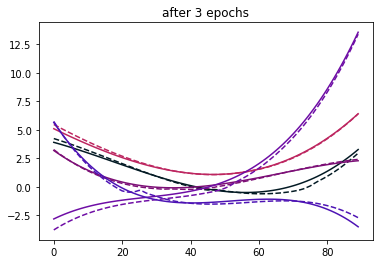

Epoch 1/6
1000/1000 [==============================] - 0s 286us/step - loss: 0.4365
Epoch 2/6
1000/1000 [==============================] - 0s 242us/step - loss: 0.1946
Epoch 3/6
1000/1000 [==============================] - 0s 236us/step - loss: 0.0356
Epoch 4/6
1000/1000 [==============================] - 0s 262us/step - loss: 0.0163
Epoch 5/6
1000/1000 [==============================] - 0s 328us/step - loss: 0.0126
Epoch 6/6
1000/1000 [==============================] - 0s 363us/step - loss: 0.0098


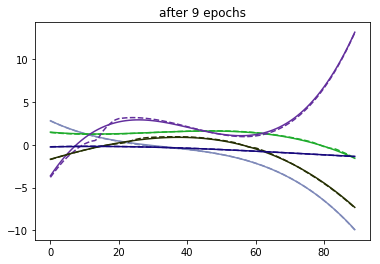


evaluating:

1000/1000 [==============================] - 0s 94us/step
loss_train: 0.008987268045544625
loss_test: 0.008883842349052429


In [56]:
model.fit(x_train, y_train, epochs=1)
pred_test = model.predict(x_test)
plot_preds(y_test, pred_test, title='after 1 epoch')

model.fit(x_train, y_train, epochs=2)
pred_test = model.predict(x_test)
plot_preds(y_test, pred_test, title='after 3 epochs')

model.fit(x_train, y_train, epochs=6)
pred_test = model.predict(x_test)
plot_preds(y_test, pred_test, title='after 9 epochs')

print('\nevaluating:\n')
loss_train = model.evaluate(x_train, y_train)
loss_test = model.evaluate(x_test, y_test)
print('loss_train:', loss_train)
print('loss_test:', loss_test)
